In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from src.comb import incremental_levels
from src.data import get_regional_data
from src.dataset import process_dataset
from src.interventions import get_delta

sns.set_context('notebook')
sns.set_style('whitegrid')

NUM_LAYERS = 3
NUM_UNITS = [8, 16, 32]
EPOCHS = 1000

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


In [2]:
df = pd.read_csv('../res/dataset.csv')
df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,98.0,49.0,1.0,106.0,118.0,1.0,107.0,89.0,3.0,116.0,...,44.0,5.0,143.0,36.0,2.0,135.0,19.0,1.0,Y,R
1,224.0,95.0,1.0,219.0,135.0,7.0,223.0,128.0,4.0,227.0,...,59.0,0.0,78.0,28.0,1.0,83.0,81.0,1.0,R,W
2,119.0,22.0,3.0,109.0,17.0,2.0,100.0,23.0,1.0,91.0,...,129.0,3.0,199.0,146.0,2.0,196.0,112.0,6.0,W,Y
3,94.0,50.0,0.0,96.0,99.0,2.0,106.0,100.0,0.0,111.0,...,27.0,3.0,144.0,21.0,1.0,138.0,15.0,5.0,Y,R
4,193.0,65.0,6.0,198.0,170.0,2.0,199.0,145.0,5.0,206.0,...,36.0,1.0,35.0,28.0,2.0,36.0,33.0,1.0,R,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,128.0,17.0,5.0,121.0,23.0,2.0,104.0,14.0,4.0,89.0,...,7.0,0.0,9.0,7.0,0.0,10.0,14.0,0.0,R,O
1396,15.0,2.0,0.0,14.0,1.0,0.0,13.0,1.0,0.0,11.0,...,3.0,0.0,18.0,1.0,0.0,13.0,0.0,1.0,O,R
1397,10.0,7.0,0.0,13.0,16.0,0.0,16.0,12.0,0.0,16.0,...,17.0,0.0,15.0,11.0,0.0,14.0,13.0,1.0,R,W
1398,11.0,1.0,1.0,6.0,2.0,1.0,5.0,2.0,0.0,4.0,...,14.0,1.0,46.0,21.0,2.0,36.0,9.0,5.0,W,O


In [3]:
(xtr, ytr), (xvl, yvl), _ = process_dataset(df, val_split=0.2)
print(f'x train: {xtr.shape}, x val: {xvl.shape}')
print(f'y train: {ytr.shape}, y val: {yvl.shape}')

x train: (1120, 53), x val: (280, 53)
y train: (1120, 3), y val: (280, 3)


In [4]:
scores = {}
configurations = incremental_levels(num_levels=NUM_LAYERS, parameters=NUM_UNITS)

for idx, config in enumerate(configurations):
    print(f'Model {idx + 1:0{len(str(len(configurations)))}}/{len(configurations)}', end='')
    start_time = time.time()
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    model = Sequential([Dense(hu, activation='relu') for hu in config] + [Dense(3)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(xtr, ytr, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=False)
    ptr, pvl = model.predict(xtr), model.predict(xvl)
    config = config + (0,) * NUM_LAYERS
    config = config[:NUM_LAYERS]
    scores[(0,) if config == () else config] = {
        'train_mse': mean_squared_error(ytr, ptr),
        'train_r2': r2_score(ytr, ptr),
        'val_mse': mean_squared_error(yvl, pvl),
        'val_r2': r2_score(yvl, pvl)
    }
    print(f' -- elapsed time: {time.time() - start_time:.4}s')

Model 01/40 -- elapsed time: 46.92s
Model 02/40 -- elapsed time: 51.52s
Model 03/40 -- elapsed time: 36.75s
Model 04/40 -- elapsed time: 58.95s
Model 05/40 -- elapsed time: 28.27s
Model 06/40 -- elapsed time: 28.61s
Model 07/40 -- elapsed time: 28.12s
Model 08/40 -- elapsed time: 34.11s
Model 09/40 -- elapsed time: 30.55s
Model 10/40 -- elapsed time: 22.58s
Model 11/40 -- elapsed time: 53.09s
Model 12/40 -- elapsed time: 25.13s
Model 13/40 -- elapsed time: 29.12s
Model 14/40 -- elapsed time: 44.37s
Model 15/40 -- elapsed time: 35.7s
Model 16/40 -- elapsed time: 21.01s
Model 17/40 -- elapsed time: 28.0s
Model 18/40 -- elapsed time: 41.99s
Model 19/40 -- elapsed time: 25.7s
Model 20/40 -- elapsed time: 20.56s
Model 21/40 -- elapsed time: 41.93s
Model 22/40 -- elapsed time: 46.93s
Model 23/40 -- elapsed time: 30.11s
Model 24/40 -- elapsed time: 34.12s
Model 25/40 -- elapsed time: 16.85s
Model 26/40 -- elapsed time: 45.15s
Model 27/40 -- elapsed time: 28.26s
Model 28/40 -- elapsed time: 35

In [5]:
results = pd.DataFrame.from_dict(scores, orient='index').sort_values('val_r2', ascending=False)
results

train_mse  train_r2   val_mse    val_r2
32 0  0    0.000234  0.989292  0.000487  0.980262
8  0  0    0.000391  0.982147  0.000546  0.977890
   16 0    0.000316  0.985513  0.000553  0.977677
32 8  32   0.000237  0.989150  0.000577  0.976607
16 0  0    0.000361  0.983526  0.000590  0.976132
   16 0    0.000316  0.985569  0.000602  0.975626
   32 0    0.000302  0.986145  0.000603  0.975566
8  8  16   0.000335  0.984643  0.000608  0.975355
   16 32   0.000345  0.984215  0.000623  0.974781
32 8  0    0.000263  0.987903  0.000642  0.973928
8  16 16   0.000320  0.985329  0.000647  0.973837
32 8  16   0.000256  0.988253  0.000648  0.973708
   16 8    0.000263  0.987966  0.000648  0.973699
      0    0.000282  0.987106  0.000655  0.973477
16 8  0    0.000332  0.984782  0.000662  0.973189
32 8  8    0.000255  0.988334  0.000663  0.973155
8  32 8    0.000378  0.982708  0.000680  0.972440
   16 8    0.000365  0.983307  0.000682  0.972387
   8  8    0.000375  0.982856  0.000687  0.972183
16 16 32   0.000218  0.990052  0.000699  0.971653
8  8  32   0.000441  0.979881  0.000712  0.971171
32 32 0    0.000224  0.989759  0.000712  0.971149
16 32 32   0.000236  0.989214  0.000723  0.970726
8  32 16   0.000283  0.987082  0.000744  0.969872
      0    0.000361  0.983506  0.000754  0.969487
16 16 8    0.000290  0.986739  0.000770  0.968860
8  8  0    0.000484  0.977929  0.000773  0.968764
16 8  8    0.000358  0.983597  0.000775  0.968668
      16   0.000286  0.986878  0.000784  0.968282
   32 16   0.000353  0.983874  0.000803  0.967533
   16 16   0.000312  0.985721  0.000807  0.967329
   8  32   0.000348  0.984046  0.000811  0.967179
   32 8    0.000325  0.985043  0.000819  0.966722
32 32 8    0.000240  0.989013  0.000829  0.966497
   16 16   0.000244  0.988825  0.000831  0.966278
   32 16   0.000370  0.983085  0.000842  0.965969
      32   0.000212  0.990252  0.000857  0.965327
   16 32   0.000318  0.985438  0.000867  0.964908
8  32 32   0.000231  0.989415  0.000927  0.962533
0  0  0    0.001005  0.954368  0.001244  0.949870

In [6]:
best_config = results.index[0]
(x, y), (x_scaler, y_scaler) = process_dataset(df, val_split=None)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model = Sequential([Dense(hu, activation='relu') for hu in best_config if hu != 0] + [Dense(3)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(x, y, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=True)

Epoch 1/1000
35/35 [==============================] - ETA: 5s - loss: 1.6893 - 0s 4ms/step - loss: 0.8445 - val_loss: 0.1376
Epoch 2/1000
35/35 [==============================] - ETA: 0s - loss: 0.1311 - 0s 2ms/step - loss: 0.1252 - val_loss: 0.0630
Epoch 3/1000
35/35 [==============================] - ETA: 0s - loss: 0.0713 - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0396
Epoch 4/1000
35/35 [==============================] - ETA: 0s - loss: 0.0376 - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0277
Epoch 5/1000
35/35 [==============================] - ETA: 0s - loss: 0.0361 - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0198
Epoch 6/1000
35/35 [==============================] - ETA: 0

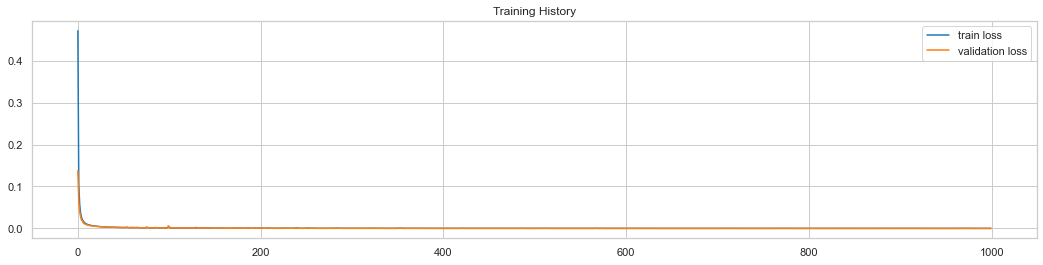

In [7]:
plt.figure(figsize=(18, 4))
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss').set(title='Training History')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')
plt.show()

MSE: 14481.6820, R2: 0.9890925566457157:.4f


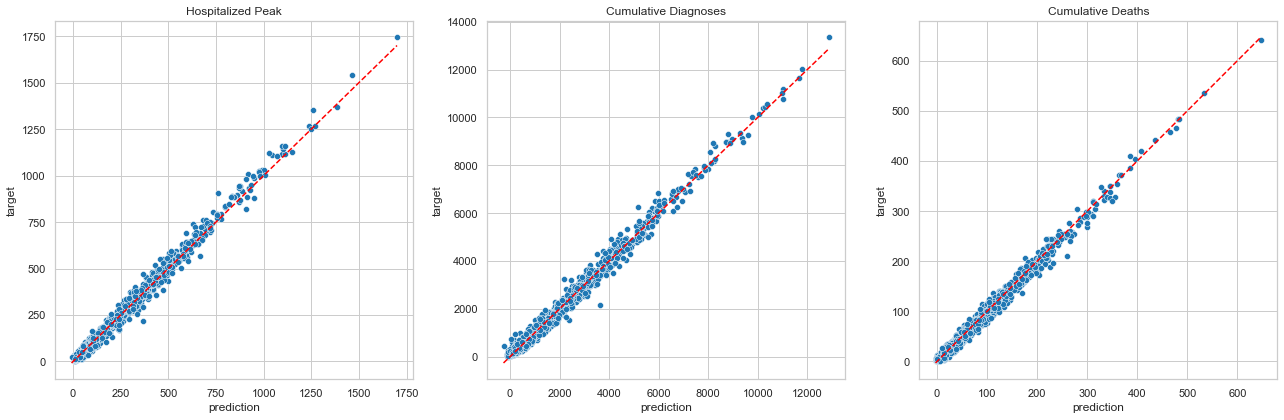

In [8]:
p = model.predict(x)
y, p = y_scaler.inverse_transform(y), y_scaler.inverse_transform(p)
print(f'MSE: {mean_squared_error(y, p):.4f}, R2: {r2_score(y, p)}:.4f')

_, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Diagnoses', 'Cumulative Deaths']):
    pp, yy = p[:, idx], y[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')

## Test Set

In [9]:
region = 'Emilia-Romagna'
tot_pop = 4.46e6
region_zones = {
    '2020-05-18': 'W',
    '2020-11-08': 'Y',
    '2020-11-15': 'O',
    '2020-12-10': 'Y',
    '2020-12-21': 'O',
    '2021-02-01': 'Y',
    '2021-02-21': 'O',
    '2021-03-01': 'R',
    '2021-04-12': 'O',
    '2021-04-26': 'Y'
}
pop_size = 400e3
df = get_regional_data(scaling_factor=tot_pop/pop_size, region=region)
df

,date,n_severe,n_critical,cum_diagnoses,cum_deaths,new_tests
0,2020-02-24,0.896861,0.179372,1.614350,0.000000,13.273543
1,2020-02-25,1.345291,0.179372,2.331839,0.000000,21.793722
2,2020-02-26,1.793722,0.269058,4.215247,0.089686,16.681614
3,2020-02-27,3.228700,0.538117,8.699552,0.089686,40.896861
4,2020-02-28,5.022422,0.538117,13.004484,0.179372,21.883408
...,...,...,...,...,...,...
427,2021-04-26,166.905830,24.035874,32799.551570,1148.071749,1134.080717
428,2021-04-27,164.394619,22.062780,32863.856502,1149.775785,2758.385650
429,2021-04-28,160.538117,22.421525,32921.165919,1151.838565,2655.515695
430,2021-04-29,158.206278,20.986547,33008.520179,1153.273543,2864.932735


In [10]:
time_interval = 21
zones = [
    (range(get_delta(d) - time_interval - 1, get_delta(d) + time_interval), z)
    for d, z in region_zones.items()
]

samples = {
    days: (init_zone, actuated_zone)
    for (_, init_zone), (days, actuated_zone) in zip(zones[:-3], zones[1:-2])
}

samples

{range(236, 279): ('W', 'Y'),
 range(243, 286): ('Y', 'O'),
 range(268, 311): ('O', 'Y'),
 range(279, 322): ('Y', 'O'),
 range(321, 364): ('O', 'Y'),
 range(341, 384): ('Y', 'O'),
 range(349, 392): ('O', 'R')}

In [11]:
real_data = []
for period, zones in samples.items():
    temp = df.iloc[period]
    row = np.concatenate((
        temp['n_severe'].values[1:] + temp['n_critical'].values[1:],
        temp['cum_diagnoses'].values[1:] - temp['cum_diagnoses'].values[:-1],
        temp['cum_deaths'].values[1:] - temp['cum_deaths'].values[:-1]
    )).reshape(3, -1).transpose().flatten()
    real_data.append(list(row) + list(zones))
columns = [f'{c}_{d}' for d in range(0, 2 * time_interval) for c in ['hosp', 'diag', 'dead']] + ['init_zone', 'actuated_zone']
real_df = pd.DataFrame(real_data, columns=columns)
real_df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,45.381166,47.174888,0.538117,49.417040,49.417040,0.269058,54.618834,45.470852,0.448430,61.165919,...,193.273543,4.932735,262.152466,194.080717,5.919283,261.704036,194.170404,6.278027,W,Y
1,75.784753,106.905830,0.358744,81.524664,102.511211,0.269058,93.004484,126.278027,1.345291,100.269058,...,157.847534,7.623318,265.919283,191.838565,5.650224,264.573991,176.143498,4.663677,Y,O
2,245.112108,193.721973,4.484305,249.147982,226.905830,4.215247,254.260090,243.946188,4.215247,261.434978,...,67.264574,2.780269,252.825112,80.000000,8.071749,257.488789,127.982063,6.188341,O,Y
3,269.417040,183.049327,3.497758,266.905830,131.659193,4.663677,263.587444,140.717489,6.188341,261.255605,...,181.524664,7.174888,261.793722,160.358744,6.188341,263.856502,196.502242,5.201794,Y,O
4,267.174888,173.991031,5.919283,266.098655,140.179372,4.573991,260.807175,105.650224,5.919283,254.977578,...,162.511211,4.125561,186.098655,153.183857,2.062780,190.403587,165.919283,3.677130,O,Y
5,207.892377,114.260090,1.973094,214.170404,94.260090,3.049327,212.914798,78.295964,6.367713,207.713004,...,253.004484,4.035874,318.116592,308.789238,3.139013,323.587444,262.242152,2.780269,Y,O
6,195.964126,114.080717,2.869955,193.094170,86.008969,4.035874,190.134529,82.600897,3.318386,186.636771,...,283.587444,3.766816,351.569507,227.623318,4.215247,355.336323,218.923767,3.049327,O,R


In [12]:
(x_test, y_test), (x_scaler, y_scaler) = process_dataset(real_df, val_split=None)
print(f'x test: {x_test.shape}, y test: {y_test.shape}')

x test: (7, 53), y test: (7, 3)


MSE: 735462.0747, R2: -1.4569213690243685:.4f


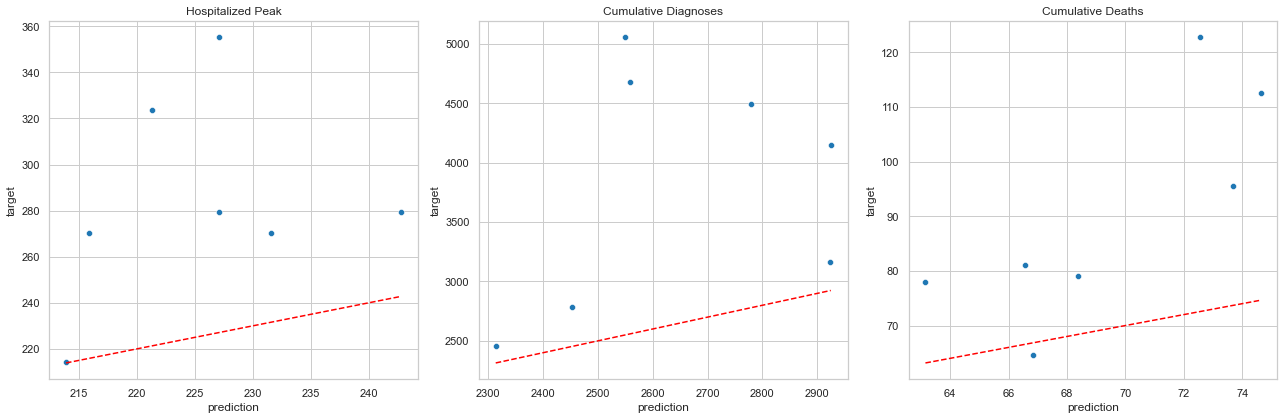

In [13]:
p_test = model.predict(x_test)
y_test, p_test = y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(p_test)
print(f'MSE: {mean_squared_error(y_test, p_test):.4f}, R2: {r2_score(y_test, p_test)}:.4f')

_, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Diagnoses', 'Cumulative Deaths']):
    pp, yy = p_test[:, idx], y_test[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')

In [14]:
model.save('../res/model')


INFO:tensorflow:Assets written to: ../res/model\assets
